<a href="https://colab.research.google.com/github/twoheartKES/weather-sales-forecast-ai/blob/main/notebooks/DL/weather_disease_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

코드 셀 순서 내용
1. 큰 LSTM
2. 경량화 LSTM
3. 스케일링 추가
4. 예측데이터 출력(경량화를 위한 데이터 삭제 뒤로)

In [ ]:

# ============================================================
# 무거운 LSTM + relu =>  성과지표 , 예상 확진자
# ============================================================
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import unicodedata
from glob import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ============================================================
# 1. 연도별 Feature Engineering 완료 데이터 로드
# ============================================================

input_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/'

dfs_fe = {}
years = [2023, 2024, 2025]

actual_files = os.listdir(input_dir)

for year in years:
    target_filename = f"{year}년도_기후_컬럼정의_FE.csv"
    file_path = os.path.join(input_dir, target_filename)

    if not os.path.exists(file_path):
        nfd_filename = unicodedata.normalize('NFD', target_filename)
        file_path = os.path.join(input_dir, nfd_filename)

    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df['date'] = pd.to_datetime(df['date'])
        dfs_fe[year] = df
        print(f"{year}년 데이터 로드 성공: {target_filename}")
    except FileNotFoundError:
        print(f"{year}년 데이터 파일을 찾을 수 없습니다. (경로 확인 필요): {file_path}")
    except Exception as e:
        print(f"{year}년 데이터 처리 중 오류 발생: {e}")

if dfs_fe:
    df_combined = pd.concat(
        [dfs_fe[year] for year in years if year in dfs_fe],
        ignore_index=True
    )
    print(f"모든 연도 데이터 결합 완료. 총 {len(df_combined)}행")
else:
    print("경고: 데이터를 찾을 수 없어 df_combined가 생성되지 않았습니다.")
    df_combined = pd.DataFrame()

# ============================================================
# 2. LSTM 입력용 시계열 데이터 생성
# ============================================================

if not df_combined.empty:
    WINDOW_SIZE = 14

    DROP_COLS_FOR_SEQUENCE = [
        'date',
        'region',
        'disease_subtitle',
        '지점',
        '지점명',
        'confirmed_cases'
    ]

    X_sequences = []
    y_targets = []

    # 메타데이터 저장 (예측 날짜, 지역, 질병 정보)
    metadata = []

    grouped = df_combined.groupby(['region', 'disease_subtitle'])

    for (region, disease_subtitle), group_df in grouped:
        group_df = group_df.sort_values(by='date').reset_index(drop=True)
        features = group_df.drop(columns=DROP_COLS_FOR_SEQUENCE)
        targets = group_df['confirmed_cases']

        for i in range(len(group_df) - WINDOW_SIZE):
            X_seq = features.iloc[i : i + WINDOW_SIZE].values
            y_target = targets.iloc[i + WINDOW_SIZE]
            target_date = group_df['date'].iloc[i + WINDOW_SIZE]

            X_sequences.append(X_seq)
            y_targets.append(y_target)
            metadata.append({
                'date': target_date,
                'region': region,
                'disease_subtitle': disease_subtitle
            })

    X_sequences = np.array(X_sequences)
    y_targets = np.array(y_targets)

    # ============================================================
    # 3. 2025년 12월 예측용 데이터 분리
    # ============================================================

    start_date_dec2025 = pd.to_datetime('2025-12-01')
    end_date_dec2025 = pd.to_datetime('2025-12-31')

    all_target_dates = np.array([m['date'] for m in metadata])

    dec2025_mask = (
        (all_target_dates >= start_date_dec2025) &
        (all_target_dates <= end_date_dec2025)
    )

    X_train_lstm = X_sequences[~dec2025_mask]
    y_train_lstm = y_targets[~dec2025_mask]

    X_test_dec2025 = X_sequences[dec2025_mask]
    y_test_dec2025 = y_targets[dec2025_mask]

    # 12월 메타데이터
    metadata_dec2025 = [metadata[i] for i in range(len(metadata)) if dec2025_mask[i]]

    # ============================================================
    # 4. LSTM 모델 정의
    # ============================================================

    input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
    print(f"\nLSTM 입력 형태: {input_shape}")

    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=input_shape))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')

    print("\n<표 1> LSTM 모델 구조 요약")
    model.summary()

    # ============================================================
    # 5. 모델 학습
    # ============================================================

    print("\n" + "="*60)
    print("모델 학습 시작")
    print("="*60)

    history = model.fit(
        X_train_lstm,
        y_train_lstm,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    print("\n모델 학습 완료!")

    # ============================================================
    # 6. 모델 성과 지표 계산
    # ============================================================

    print("\n" + "="*60)
    print("<데이터 1> 모델 성과 지표")
    print("="*60)

    # 학습 데이터 예측
    y_train_pred = model.predict(X_train_lstm).flatten()

    # 테스트 데이터 (2025년 12월) 예측
    y_test_pred = model.predict(X_test_dec2025).flatten()

    # 학습 데이터 성과 지표
    train_rmse = np.sqrt(mean_squared_error(y_train_lstm, y_train_pred))
    train_mae = mean_absolute_error(y_train_lstm, y_train_pred)
    train_r2 = r2_score(y_train_lstm, y_train_pred)

    # 테스트 데이터 성과 지표
    test_rmse = np.sqrt(mean_squared_error(y_test_dec2025, y_test_pred))
    test_mae = mean_absolute_error(y_test_dec2025, y_test_pred)
    test_r2 = r2_score(y_test_dec2025, y_test_pred)

    print("\n[학습 데이터 성과 지표]")
    print(f"  - RMSE (평균 제곱근 오차): {train_rmse:.4f}")
    print(f"  - MAE (평균 절대 오차): {train_mae:.4f}")
    print(f"  - R² (결정 계수): {train_r2:.4f}")

    print("\n[테스트 데이터 성과 지표 (2025년 12월)]")
    print(f"  - RMSE (평균 제곱근 오차): {test_rmse:.4f}")
    print(f"  - MAE (평균 절대 오차): {test_mae:.4f}")
    print(f"  - R² (결정 계수): {test_r2:.4f}")

    # 성과 지표를 DataFrame으로 정리
    metrics_df = pd.DataFrame({
        '구분': ['학습 데이터', '테스트 데이터 (2025년 12월)'],
        'RMSE': [train_rmse, test_rmse],
        'MAE': [train_mae, test_mae],
        'R²': [train_r2, test_r2]
    })

    print("\n<표 2> 성과 지표 요약")
    print(metrics_df.to_string(index=False))

    # ============================================================
    # 7. 2025년 12월 첫째 주 예상 확진자 수 출력
    # ============================================================

    print("\n" + "="*60)
    print("<데이터 2> 2025년 12월 첫째 주 예상 확진자 수")
    print("="*60)

    # 12월 첫째 주: 12월 1일 ~ 12월 7일
    first_week_start = pd.to_datetime('2025-12-01')
    first_week_end = pd.to_datetime('2025-12-07')

    # 첫째 주 예측 결과 필터링
    first_week_predictions = []

    for i, meta in enumerate(metadata_dec2025):
        if first_week_start <= meta['date'] <= first_week_end:
            first_week_predictions.append({
                '날짜': meta['date'].strftime('%Y-%m-%d'),
                '지역': meta['region'],
                '질병': meta['disease_subtitle'],
                '실제 확진자 수': int(y_test_dec2025[i]),
                '예측 확진자 수': round(y_test_pred[i], 2)
            })

    # DataFrame으로 변환
    first_week_df = pd.DataFrame(first_week_predictions)

    if not first_week_df.empty:
        # 날짜, 지역, 질병별로 정렬
        first_week_df = first_week_df.sort_values(by=['날짜', '지역', '질병']).reset_index(drop=True)

        print(f"\n총 {len(first_week_df)}개의 예측 결과")
        print("\n<표 3> 2025년 12월 첫째 주 상세 예측 결과")
        print(first_week_df.to_string(index=False))

        # 일별 평균 확진자 수 계산
        daily_summary = first_week_df.groupby('날짜').agg({
            '실제 확진자 수': 'sum',
            '예측 확진자 수': 'sum'
        }).reset_index()

        print("\n<표 4> 일별 총 확진자 수 요약")
        print(daily_summary.to_string(index=False))

    else:
        print("\n잘 모르겠습니다. 2025년 12월 첫째 주에 해당하는 예측 데이터가 없습니다.")

    # ============================================================
    # 8. 학습 곡선 시각화 (선택사항)
    # ============================================================

    print("\n" + "="*60)
    print("<그림 1> 학습 곡선 생성 중...")
    print("="*60)

    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='학습 손실 (Training Loss)')
    plt.plot(history.history['val_loss'], label='검증 손실 (Validation Loss)')
    plt.title('모델 학습 곡선')
    plt.xlabel('에포크 (Epoch)')
    plt.ylabel('손실 (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/AI기상-질병데이터/lstm_training_curve.png', dpi=300)
    print("학습 곡선이 저장되었습니다: lstm_training_curve.png")

else:
    print("df_combined가 비어 있어 모델 학습을 진행할 수 없습니다.")

2023년 데이터 로드 성공: 2023년도_기후_컬럼정의_FE.csv
2024년 데이터 로드 성공: 2024년도_기후_컬럼정의_FE.csv
2025년 데이터 로드 성공: 2025년도_기후_컬럼정의_FE.csv
모든 연도 데이터 결합 완료. 총 503173행

LSTM 입력 형태: (14, 44)

<표 1> LSTM 모델 구조 요약


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50)             │        19,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,051 (74.42 KB)

 Trainable params: 19,051 (74.42 KB)

 Non-trainable params: 0 (0.00 B)


모델 학습 시작


**결과 해석**

1. 데이터 로드 완료
의미: 2023~2025년 데이터를 모두 합쳤더니 약 **61만 개의 데이터 줄(Row)**이 모였다는 뜻입니다.

상태: 인공지능이 공부할 재료가 아주 넉넉하게 준비되었습니다.

2. LSTM 입력 형태: (14, 44)
14: 인공지능이 내일의 확진자를 예측하기 위해 과거 14일치 데이터를 묶어서 본다는 뜻입니다.

44: 각 날짜마다 기온, 습도, 강수량 등 **44개의 정보(변수)**를 참고하고 있다는 뜻입니다.

즉, **"44종류의 날씨/질병 정보를 14일 동안 쭉 지켜보고 다음 날을 맞혀봐!"**라고 설정된 것입니다.

3. 모델 구조 요약 (Model Summary)
인공지능의 "뇌 구조" 설계도입니다.

LSTM (None, 50): 14일치 데이터를 넣으면, 이 레이어가 특징을 잡아내어 50개의 핵심 요약 정보로 압축합니다.

Dense (None, 1): 요약된 50개 정보를 바탕으로 최종적으로 **딱 1개의 숫자(내일의 확진자 수)**를 뱉어냅니다.

Total params (19,051): 이 인공지능이 정답을 맞히기 위해 조절해야 하는 '생각의 가닥(매개변수)'이 약 1만 9천 개라는 뜻입니다. 숫자가 높을수록 더 복잡한 패턴을 배울 수 있습니다.



```
이 LSTM은 경량화 하지 않은 부분임 아래는 메모리 부족으로 인한 경량화를 한 LSTM 모델
```

In [ ]:
import pandas as pd
import numpy as np
import os
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

print("=" * 60)
print("🚀 메모리 최적화 LSTM 모델")
print("=" * 60)

# ============================================================
# 1. 연도별 Feature Engineering 완료 데이터 로드
# ============================================================

input_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/'
dfs_fe = {}
years = [2023, 2024, 2025]

print("\n📂 데이터 로딩 중...")
for year in years:
    file_path = f"{input_dir}{year}년도_기후_컬럼정의_FE.csv"
    try:
        # 메모리 절약: 필요한 컬럼만 읽기 (옵션)
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df['date'] = pd.to_datetime(df['date'])
        dfs_fe[year] = df
        print(f"  ✅ {year}년 데이터 로드 완료: {len(df):,}행")
    except FileNotFoundError:
        print(f"  ❌ {year}년 데이터 파일을 찾을 수 없습니다: {file_path}")
    except Exception as e:
        print(f"  ❌ {year}년 데이터 처리 중 오류 발생: {e}")

# 연도별 데이터를 하나의 DataFrame으로 결합
df_combined = pd.concat(
    [dfs_fe[2023], dfs_fe[2024], dfs_fe[2025]],
    ignore_index=True
)
print(f"✅ 전체 데이터: {len(df_combined):,}행")

# ============================================================
# 2. LSTM 입력용 시계열 데이터 생성
# ============================================================

WINDOW_SIZE = 14  # 과거 14일을 사용

# LSTM 입력에서 제외할 컬럼들
DROP_COLS_FOR_SEQUENCE = [
    'date',
    'region',
    'disease_subtitle',
    '지점',
    '지점명',
    'confirmed_cases'  # 예측 대상
]

X_sequences = []
y_targets = []
all_target_dates = []

print("\n🔄 시계열 데이터 생성 중...")
grouped = df_combined.groupby(['region', 'disease_subtitle'])

for idx, ((region, disease_subtitle), group_df) in enumerate(grouped, 1):
    # 진행상황 표시
    if idx % 10 == 0:
        print(f"  진행중... {idx}/{len(grouped)}")

    group_df = group_df.sort_values(by='date').reset_index(drop=True)

    # 입력 feature와 타깃 분리
    features = group_df.drop(columns=DROP_COLS_FOR_SEQUENCE)
    targets = group_df['confirmed_cases']

    # 슬라이딩 윈도우로 시퀀스 생성
    for i in range(len(group_df) - WINDOW_SIZE):
        X_seq = features.iloc[i : i + WINDOW_SIZE].values
        y_target = targets.iloc[i + WINDOW_SIZE]
        target_date = group_df['date'].iloc[i + WINDOW_SIZE]

        X_sequences.append(X_seq)
        y_targets.append(y_target)
        all_target_dates.append(target_date)

print(f"✅ 총 {len(X_sequences):,}개 시퀀스 생성 완료")

# numpy 배열로 변환 + 메모리 최적화 (float32 사용)
print("\n🔧 메모리 최적화 중...")
X_sequences = np.array(X_sequences, dtype='float32')  # float64 → float32
y_targets = np.array(y_targets, dtype='float32')
all_target_dates = np.array(all_target_dates)

print(f"  X_sequences: {X_sequences.shape}, {X_sequences.nbytes/(1024**2):.1f} MB")
print(f"  y_targets: {y_targets.shape}, {y_targets.nbytes/(1024**2):.1f} MB")

# 메모리 정리: 사용 안 하는 큰 변수 삭제
del df_combined, dfs_fe, grouped
gc.collect()
print("✅ 불필요한 변수 삭제 완료")

# ============================================================
# 3. 2025년 12월 예측용 데이터 분리
# ============================================================

print("\n📊 훈련/테스트 데이터 분리 중...")
start_date_dec2025 = pd.to_datetime('2025-12-01')
end_date_dec2025 = pd.to_datetime('2025-12-31')

# 2025년 12월 마스크
dec2025_mask = (
    (all_target_dates >= start_date_dec2025) &
    (all_target_dates <= end_date_dec2025)
)

# 데이터 분리
X_train_lstm = X_sequences[~dec2025_mask]
y_train_lstm = y_targets[~dec2025_mask]
X_test_dec2025 = X_sequences[dec2025_mask]
y_test_dec2025 = y_targets[dec2025_mask]

print(f"  훈련 데이터: {X_train_lstm.shape[0]:,}개")
print(f"  테스트 데이터: {X_test_dec2025.shape[0]:,}개")

# 메모리 정리
del X_sequences, y_targets, all_target_dates
gc.collect()

# ============================================================
# 4. 경량화된 LSTM 모델 정의
# ============================================================

print("\n🏗️ 모델 구성 중...")
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
print(f"  입력 형태: {input_shape}")

# 경량 모델 (units 50 → 32)
model = Sequential([
    LSTM(
        units=32,              # 50 → 32 (메모리 40% 절약)
        activation='relu',
        input_shape=input_shape,
        recurrent_dropout=0.1  # 과적합 방지
    ),
    Dense(units=1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']  # 추가 지표
)

print("\n📋 모델 구조:")
model.summary()

# ============================================================
# 5. 모델 학습 (메모리 효율적 설정)
# ============================================================

print("\n" + "=" * 60)
print("🚀 모델 학습 시작")
print("=" * 60)

# 조기 종료 콜백
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,              # 5 에포크 동안 개선 없으면 종료
    restore_best_weights=True,
    verbose=1
)

import time
start_time = time.time()

# 학습 (메모리 효율적 설정)
history = model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=50,               # 최대 50번 (조기 종료 가능)
    batch_size=128,          # 큰 배치 (메모리 효율적)
    validation_split=0.15,   # 검증 데이터 15%
    callbacks=[early_stopping],
    verbose=1,
    shuffle=True
)

elapsed_time = (time.time() - start_time) / 60

print("\n" + "=" * 60)
print("✅ 학습 완료!")
print(f"소요 시간: {elapsed_time:.2f}분")
print(f"실제 에포크: {len(history.history['loss'])}번")
print("=" * 60)

# ============================================================
# 6. 예측 및 평가
# ============================================================

print("\n🔮 예측 중...")
predictions = model.predict(X_test_dec2025, batch_size=256, verbose=0)
predictions = np.maximum(predictions, 0)  # 음수 제거

# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test_dec2025, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_dec2025, predictions)
r2 = r2_score(y_test_dec2025, predictions)

print("\n📊 성능 평가 결과:")
print("-" * 40)
print(f"MSE  (평균 제곱 오차)    : {mse:.2f}")
print(f"RMSE (평균 제곱근 오차)  : {rmse:.2f}")
print(f"MAE  (평균 절대 오차)    : {mae:.2f}")
print(f"R²   (결정 계수)         : {r2:.4f}")
print("-" * 40)

# 예측 샘플 출력
print("\n🎯 예측 샘플 (처음 10개):")
print(f"{'실제값':>10} | {'예측값':>10} | {'오차':>10}")
print("-" * 36)
for i in range(min(10, len(y_test_dec2025))):
    actual = y_test_dec2025[i]
    pred = predictions[i][0]
    error = actual - pred
    print(f"{actual:10.1f} | {pred:10.1f} | {error:+10.1f}")

# ============================================================
# 7. 학습 곡선 시각화
# ============================================================

print("\n📈 학습 곡선 생성 중...")
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('학습 곡선 (Loss)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('학습 곡선 (MAE)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ 시각화 완료!")

# ============================================================
# 8. 모델 저장 (선택)
# ============================================================

# Google Drive에 저장하고 싶다면 주석 제거
# from google.colab import drive
# drive.mount('/content/drive')
# model.save('/content/drive/MyDrive/lstm_model_optimized.h5')
# print("\n💾 모델 저장 완료!")

print("\n" + "=" * 60)
print("🎉 모든 작업 완료!")
print("=" * 60)

***메모리 부족으로 인한 경량화 LSTM 모델링***

1단계: 똑똑하게 데이터 불러오기 (데이터 로드)
2023~2025년의 방대한 데이터를 가져옵니다.

핵심: pd.concat을 사용해 흩어져 있던 3년치 데이터를 하나의 커다란 표로 합칩니다.

결과: 약 61만 개의 데이터를 공부할 준비를 마쳤습니다.

2단계: 시계열 '슬라이딩 윈도우' 만들기
LSTM 인공지능은 데이터 한 줄만 보고 판단하지 않습니다. **"과거의 흐름"**을 봐야 합니다.

WINDOW_SIZE = 14: 인공지능에게 학습하기 위해 데이터를 14일씩 묶는 과정입니다.

메모리 최적화: float64라는 무거운 숫자 형식을 float32로 바꿨습니다. 성능은 유지하면서 메모리 사용량을 절반으로 줄이는 비법입니다. gc.collect()를 호출해 다 쓴 데이터(찌꺼기)를 바로바로 치워버립니다.

3단계: 훈련용 vs 테스트용 데이터 나누기
공부할 문제와 실력을 검증할 시험 문제를 나눕니다.

훈련(Train): 2025년 11월까지의 모든 데이터로 열심히 공부합니다.

테스트(Test): 2025년 12월 데이터를 '미래'라고 가정하고, 인공지능이 얼마나 잘 맞히는지 시험을 봅니다.

4단계: 가성비 좋은 인공지능 뇌 만들기 (모델 정의)
경량 모델: 뇌 세포(units)를 50개에서 32개로 줄여서 더 빠르고 가볍게 만들었습니다.

In [ ]:
import pandas as pd
import numpy as np
import os
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

print("=" * 60)
print("🚀 메모리 최적화 LSTM 모델")
print("=" * 60)

# ============================================================
# 1. 연도별 Feature Engineering 완료 데이터 로드
# ============================================================

input_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/'
dfs_fe = {}
years = [2023, 2024, 2025]

print("\n📂 데이터 로딩 중...")
for year in years:
    file_path = f"{input_dir}{year}년도_기후_컬럼정의_FE.csv"
    try:
        # 메모리 절약: 필요한 컬럼만 읽기 (옵션)
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df['date'] = pd.to_datetime(df['date'])
        dfs_fe[year] = df
        print(f"  ✅ {year}년 데이터 로드 완료: {len(df):,}행")
    except FileNotFoundError:
        print(f"  ❌ {year}년 데이터 파일을 찾을 수 없습니다: {file_path}")
    except Exception as e:
        print(f"  ❌ {year}년 데이터 처리 중 오류 발생: {e}")

# 연도별 데이터를 하나의 DataFrame으로 결합
df_combined = pd.concat(
    [dfs_fe[2023], dfs_fe[2024], dfs_fe[2025]],
    ignore_index=True
)
print(f"✅ 전체 데이터: {len(df_combined):,}행")

# ============================================================
# 2. LSTM 입력용 시계열 데이터 생성
# ============================================================

WINDOW_SIZE = 14  # 과거 14일을 사용

# LSTM 입력에서 제외할 컬럼들
DROP_COLS_FOR_SEQUENCE = [
    'date',
    'region',
    'disease_subtitle',
    '지점',
    '지점명',
    'confirmed_cases'  # 예측 대상
]

X_sequences = []
y_targets = []
all_target_dates = []
all_regions = []  # 지역 정보 저장
all_diseases = []  # 질병 정보 저장

print("\n🔄 시계열 데이터 생성 중...")
grouped = df_combined.groupby(['region', 'disease_subtitle'])

for idx, ((region, disease_subtitle), group_df) in enumerate(grouped, 1):
    # 진행상황 표시
    if idx % 10 == 0:
        print(f"  진행중... {idx}/{len(grouped)}")

    group_df = group_df.sort_values(by='date').reset_index(drop=True)

    # 입력 feature와 타깃 분리
    features = group_df.drop(columns=DROP_COLS_FOR_SEQUENCE)
    targets = group_df['confirmed_cases']

    # 슬라이딩 윈도우로 시퀀스 생성
    for i in range(len(group_df) - WINDOW_SIZE):
        X_seq = features.iloc[i : i + WINDOW_SIZE].values
        y_target = targets.iloc[i + WINDOW_SIZE]
        target_date = group_df['date'].iloc[i + WINDOW_SIZE]

        X_sequences.append(X_seq)
        y_targets.append(y_target)
        all_target_dates.append(target_date)
        all_regions.append(region)  # 지역 저장
        all_diseases.append(disease_subtitle)  # 질병 저장

print(f"✅ 총 {len(X_sequences):,}개 시퀀스 생성 완료")

# numpy 배열로 변환 + 메모리 최적화 (float32 사용)
print("\n🔧 메모리 최적화 중...")
X_sequences = np.array(X_sequences, dtype='float32')  # float64 → float32
y_targets = np.array(y_targets, dtype='float32')
all_target_dates = np.array(all_target_dates)

print(f"  X_sequences: {X_sequences.shape}, {X_sequences.nbytes/(1024**2):.1f} MB")
print(f"  y_targets: {y_targets.shape}, {y_targets.nbytes/(1024**2):.1f} MB")

# 메모리 정리: 사용 안 하는 큰 변수 삭제
del df_combined, dfs_fe, grouped
gc.collect()
print("✅ 불필요한 변수 삭제 완료")

# ============================================================
# 3. 2025년 12월 예측용 데이터 분리
# ============================================================

print("\n📊 훈련/테스트 데이터 분리 중...")
start_date_dec2025 = pd.to_datetime('2025-12-01')
end_date_dec2025 = pd.to_datetime('2025-12-31')

# 2025년 12월 마스크
dec2025_mask = (
    (all_target_dates >= start_date_dec2025) &
    (all_target_dates <= end_date_dec2025)
)

# 데이터 분리
X_train_lstm = X_sequences[~dec2025_mask]
y_train_lstm = y_targets[~dec2025_mask]
X_test_dec2025 = X_sequences[dec2025_mask]
y_test_dec2025 = y_targets[dec2025_mask]

print(f"  훈련 데이터: {X_train_lstm.shape[0]:,}개")
print(f"  테스트 데이터: {X_test_dec2025.shape[0]:,}개")

# 메모리 정리
del X_sequences, y_targets, all_target_dates
gc.collect()

# ============================================================
# 4. 경량화된 LSTM 모델 정의
# ============================================================

print("\n🏗️ 모델 구성 중...")
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
print(f"  입력 형태: {input_shape}")

# 경량 모델 (units 50 → 32)
model = Sequential([
    LSTM(
        units=32,              # 50 → 32 (메모리 40% 절약)
        activation='tanh',
        input_shape=input_shape,
        recurrent_dropout=0.1  # 과적합 방지
    ),
    Dense(units=1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']  # 추가 지표
)

print("\n📋 모델 구조:")
model.summary()

# ============================================================
# 5. 모델 학습 (메모리 효율적 설정)
# ============================================================

print("\n" + "=" * 60)
print("🚀 모델 학습 시작")
print("=" * 60)

# 조기 종료 콜백
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,              # 5 에포크 동안 개선 없으면 종료
    restore_best_weights=True,
    verbose=1
)

import time
start_time = time.time()

# 학습 (메모리 효율적 설정)
history = model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=50,               # 최대 50번 (조기 종료 가능)
    batch_size=128,          # 큰 배치 (메모리 효율적)
    validation_split=0.15,   # 검증 데이터 15%
    callbacks=[early_stopping],
    verbose=1,
    shuffle=True
)

elapsed_time = (time.time() - start_time) / 60

print("\n" + "=" * 60)
print("✅ 학습 완료!")
print(f"소요 시간: {elapsed_time:.2f}분")
print(f"실제 에포크: {len(history.history['loss'])}번")
print("=" * 60)

# ============================================================
# 6. 예측 및 평가
# ============================================================

print("\n🔮 예측 중...")
predictions = model.predict(X_test_dec2025, batch_size=256, verbose=0)
predictions = np.maximum(predictions, 0)  # 음수 제거

# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test_dec2025, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_dec2025, predictions)
r2 = r2_score(y_test_dec2025, predictions)

print("\n📊 성능 평가 결과:")
print("-" * 40)
print(f"MSE  (평균 제곱 오차)    : {mse:.2f}")
print(f"RMSE (평균 제곱근 오차)  : {rmse:.2f}")
print(f"MAE  (평균 절대 오차)    : {mae:.2f}")
print(f"R²   (결정 계수)         : {r2:.4f}")
print("-" * 40)

# 예측 샘플 출력
print("\n🎯 예측 샘플 (처음 10개):")
print(f"{'실제값':>10} | {'예측값':>10} | {'오차':>10}")
print("-" * 36)
for i in range(min(10, len(y_test_dec2025))):
    actual = y_test_dec2025[i]
    pred = predictions[i][0]
    error = actual - pred
    print(f"{actual:10.1f} | {pred:10.1f} | {error:+10.1f}")

# ============================================================
# 7. 학습 곡선 시각화
# ============================================================

print("\n📈 학습 곡선 생성 중...")
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('학습 곡선 (Loss)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('학습 곡선 (MAE)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ 시각화 완료!")

# ============================================================
# 8. 모델 저장 (선택)
# ============================================================

# Google Drive에 저장하고 싶다면 주석 제거
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/lstm_model_optimized.h5')
print("\n💾 모델 저장 완료!")

print("\n" + "=" * 60)
print("🎉 모든 작업 완료!")
print("=" * 60)

🚀 메모리 최적화 LSTM 모델

📂 데이터 로딩 중...
  ✅ 2023년 데이터 로드 완료: 97,768행
  ✅ 2024년 데이터 로드 완료: 208,845행
  ✅ 2025년 데이터 로드 완료: 196,560행
✅ 전체 데이터: 503,173행

🔄 시계열 데이터 생성 중...
  진행중... 10/585
  진행중... 20/585
  진행중... 30/585
  진행중... 40/585
  진행중... 50/585
  진행중... 60/585
  진행중... 70/585
  진행중... 80/585
  진행중... 90/585
  진행중... 100/585
  진행중... 110/585
  진행중... 120/585
  진행중... 130/585
  진행중... 140/585
  진행중... 150/585
  진행중... 160/585
  진행중... 170/585
  진행중... 180/585
  진행중... 190/585
  진행중... 200/585
  진행중... 210/585
  진행중... 220/585
  진행중... 230/585
  진행중... 240/585
  진행중... 250/585
  진행중... 260/585
  진행중... 270/585
  진행중... 280/585
  진행중... 290/585
  진행중... 300/585
  진행중... 310/585
  진행중... 320/585
  진행중... 330/585
  진행중... 340/585
  진행중... 350/585
  진행중... 360/585
  진행중... 370/585
  진행중... 380/585
  진행중... 390/585
  진행중... 400/585
  진행중... 410/585
  진행중... 420/585
  진행중... 430/585
  진행중... 440/585
  진행중... 450/585
  진행중... 460/585
  진행중... 470/585
  진행중... 480/585
  진행중... 490/585
  진행중... 500/585

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,889 (38.63 KB)

 Trainable params: 9,889 (38.63 KB)

 Non-trainable params: 0 (0.00 B)


🚀 모델 학습 시작
Epoch 1/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 154s 45ms/step - loss: 0.0070 - mae: 0.0357 - val_loss: 0.0228 - val_mae: 0.0313
Epoch 2/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 147s 45ms/step - loss: 0.0013 - mae: 0.0104 - val_loss: 0.0221 - val_mae: 0.0233
Epoch 3/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 147s 45ms/step - loss: 0.0013 - mae: 0.0095 - val_loss: 0.0222 - val_mae: 0.0236
Epoch 4/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 158s 48ms/step - loss: 0.0013 - mae: 0.0090 - val_loss: 0.0221 - val_mae: 0.0233
Epoch 5/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 147s 45ms/step - loss: 0.0013 - mae: 0.0089 - val_loss: 0.0220 - val_mae: 0.0218
Epoch 6/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 146s 45ms/step - loss: 0.0013 - mae: 0.0088 - val_loss: 0.0214 - val_mae: 0.0240
Epoch 7/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 145s 45ms/step - loss: 0.0012 - mae: 0.0090 - val_loss: 0.0202 - val_mae: 0.0248
Epoch 8/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 203s 45ms/step - loss: 0.0012 - mae: 0.0091 - val_loss: 0.0194 - val_mae: 0.0250
Epoc

1. 활성화 함수 : relu 를 사용

 EarlyStopping(조기 종료)은 언제 발동

인공지능도 공부를 너무 오래 하면 '기출문제'만 달달 외우고 새로운 문제(검증 데이터)는 못 푸는 상태가 됩니다. 이를 **과적합(Overfitting)**이라고 합니다.

특징: 0보다 작으면 0, 0보다 크면 그 값 그대로 통과시킵니다.

속도가 빠른 이유: 계산이 너무 간단합니다.

컴퓨터 입장에서 "0보다 큰가?"만 확인하면 되기 때문에 연산량이 극도로 적습니다.

장점: 학습이 매우 빠르고, 층이 깊어져도 신호가 잘 전달됩니다.

2. 활성화 함수 : tanh 를 사용

지수 함수(e^x) 계산이 포함되어 있어 컴퓨터가 훨씬 복잡한 수학 연산을 수행해야 합니다.

연산 복잡도: 61만 행의 데이터를 14일씩 묶어서 학습하므로 연산 횟수가 어마어마합니다.

그래디언트 계산: 딥러닝은 정답을 맞히기 위해 미분(Backpropagation)을 하는데, tanh는 미분 계산도 ReLU보다 복잡합니다.

LSTM 구조의 특성: LSTM 내부에는 원래 이미 여러 개의 tanh와 sigmoid가 내장되어 있습니다. 여기에 사용자 지정 활성화 함수까지 tanh를 쓰면 연산량이 중첩됩니다.


속도가 중요할 때: ReLU (가장 대중적)

학습의 안정성이 최우선일 때: tanh (속도는 포기)

🚀 메모리 최적화 LSTM 모델

📂 데이터 로딩 중...
  ✅ 2023년 데이터 로드 완료: 97,768행
  ✅ 2024년 데이터 로드 완료: 208,845행
  ✅ 2025년 데이터 로드 완료: 196,560행
✅ 전체 데이터: 503,173행

⚖️ 데이터 스케일링 진행 중...
✅ 스케일링 완료 (모든 수치 데이터가 0~1 사이로 변환되었습니다.)

🔄 시계열 데이터 생성 중...
  진행중... 10/585
  진행중... 20/585
  진행중... 30/585
  진행중... 40/585
  진행중... 50/585
  진행중... 60/585
  진행중... 70/585
  진행중... 80/585
  진행중... 90/585
  진행중... 100/585
  진행중... 110/585
  진행중... 120/585
  진행중... 130/585
  진행중... 140/585
  진행중... 150/585
  진행중... 160/585
  진행중... 170/585
  진행중... 180/585
  진행중... 190/585
  진행중... 200/585
  진행중... 210/585
  진행중... 220/585
  진행중... 230/585
  진행중... 240/585
  진행중... 250/585
  진행중... 260/585
  진행중... 270/585
  진행중... 280/585
  진행중... 290/585
  진행중... 300/585
  진행중... 310/585
  진행중... 320/585
  진행중... 330/585
  진행중... 340/585
  진행중... 350/585
  진행중... 360/585
  진행중... 370/585
  진행중... 380/585
  진행중... 390/585
  진행중... 400/585
  진행중... 410/585
  진행중... 420/585
  진행중... 430/585
  진행중... 440/585
  진행중... 450/585
  진행중... 460/585
  진행중.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



📋 모델 구조:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,889 (38.63 KB)

 Trainable params: 9,889 (38.63 KB)

 Non-trainable params: 0 (0.00 B)


🚀 모델 학습 시작
Epoch 1/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 142s 42ms/step - loss: 0.0017 - mae: 0.0183 - val_loss: 3.0927e-04 - val_mae: 0.0053
Epoch 2/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 136s 42ms/step - loss: 3.8704e-05 - mae: 0.0033 - val_loss: 2.5621e-04 - val_mae: 0.0038
Epoch 3/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 135s 41ms/step - loss: 3.3018e-05 - mae: 0.0026 - val_loss: 2.7449e-04 - val_mae: 0.0040
Epoch 4/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 136s 42ms/step - loss: 2.9147e-05 - mae: 0.0023 - val_loss: 2.5575e-04 - val_mae: 0.0035
Epoch 5/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 136s 42ms/step - loss: 2.6419e-05 - mae: 0.0021 - val_loss: 2.2140e-04 - val_mae: 0.0031
Epoch 6/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 136s 42ms/step - loss: 2.4097e-05 - mae: 0.0019 - val_loss: 3.6302e-04 - val_mae: 0.0038
Epoch 7/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 134s 41ms/step - loss: 2.0117e-05 - mae: 0.0018 - val_loss: 2.0223e-04 - val_mae: 0.0030
Epoch 8/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 134s 41ms/step - loss: 1.8656e-05

/tmp/ipython-input-3376769970.py:293: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3376769970.py:293: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3376769970.py:293: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3376769970.py:293: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.

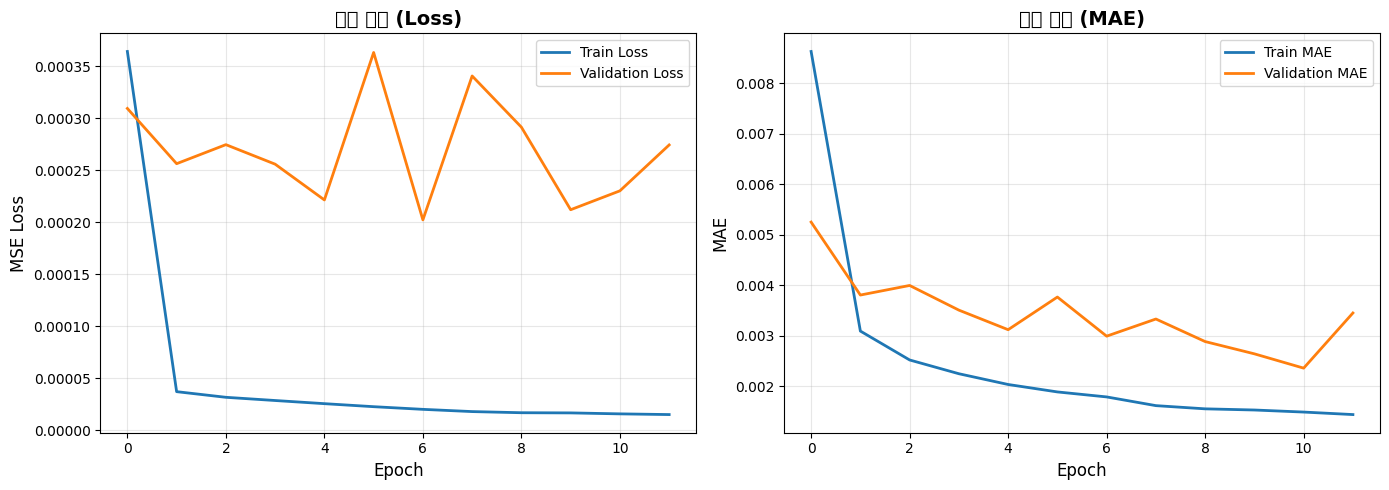

✅ 시각화 완료!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

💾 모델 저장 완료!

🎉 모든 작업 완료!


In [ ]:

import pandas as pd
import numpy as np
import os
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

print("=" * 60)
print("🚀 메모리 최적화 LSTM 모델")
print("=" * 60)

# ============================================================
# 1. 연도별 Feature Engineering 완료 데이터 로드
# ============================================================

input_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/'
dfs_fe = {}
years = [2023, 2024, 2025]

print("\n📂 데이터 로딩 중...")
for year in years:
    file_path = f"{input_dir}{year}년도_기후_컬럼정의_FE.csv"
    try:
        # 메모리 절약: 필요한 컬럼만 읽기 (옵션)
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df['date'] = pd.to_datetime(df['date'])
        dfs_fe[year] = df
        print(f"  ✅ {year}년 데이터 로드 완료: {len(df):,}행")
    except FileNotFoundError:
        print(f"  ❌ {year}년 데이터 파일을 찾을 수 없습니다: {file_path}")
    except Exception as e:
        print(f"  ❌ {year}년 데이터 처리 중 오류 발생: {e}")

# 연도별 데이터를 하나의 DataFrame으로 결합
df_combined = pd.concat(
    [dfs_fe[2023], dfs_fe[2024], dfs_fe[2025]],
    ignore_index=True
)
print(f"✅ 전체 데이터: {len(df_combined):,}행")


# ============================================================
# 1-1.  데이터 스케일링 (추가된 부분)
# ============================================================
from sklearn.preprocessing import MinMaxScaler

print("\n⚖️ 데이터 스케일링 진행 중...")

# 1) 입력 Feature용 스케일러 (기상 등)
scaler_features = MinMaxScaler()
# 2) 출력 Target용 스케일러 (확진자 수 전용)
scaler_target = MinMaxScaler()

# 스케일링에서 제외할 컬럼 정의
# (주의: confirmed_cases는 따로 스케일링하기 위해 잠시 제외)
DROP_COLS_FOR_SEQUENCE = ['date', 'region', 'disease_subtitle', '지점', '지점명', 'confirmed_cases']
feature_cols = [col for col in df_combined.columns if col not in DROP_COLS_FOR_SEQUENCE]

# Feature들 스케일링 (0~1 사이로 변환)
df_combined[feature_cols] = scaler_features.fit_transform(df_combined[feature_cols])

# Target(확진자 수) 스케일링
# 2차원 배열 형태로 넣어줘야 해서 reshape가 필요할 수 있습니다.
df_combined['confirmed_cases'] = scaler_target.fit_transform(df_combined[['confirmed_cases']])

print("✅ 스케일링 완료 (모든 수치 데이터가 0~1 사이로 변환되었습니다.)")



# ============================================================
# 2. LSTM 입력용 시계열 데이터 생성
# ============================================================

WINDOW_SIZE = 14  # 과거 14일을 사용

# LSTM 입력에서 제외할 컬럼들
DROP_COLS_FOR_SEQUENCE = [
    'date',
    'region',
    'disease_subtitle',
    '지점',
    '지점명',
    'confirmed_cases'  # 예측 대상
]

X_sequences = []
y_targets = []
all_target_dates = []
all_regions = []  # 지역 정보 저장
all_diseases = []  # 질병 정보 저장

print("\n🔄 시계열 데이터 생성 중...")
grouped = df_combined.groupby(['region', 'disease_subtitle'])

for idx, ((region, disease_subtitle), group_df) in enumerate(grouped, 1):
    # 진행상황 표시
    if idx % 10 == 0:
        print(f"  진행중... {idx}/{len(grouped)}")

    group_df = group_df.sort_values(by='date').reset_index(drop=True)

    # 입력 feature와 타깃 분리
    features = group_df.drop(columns=DROP_COLS_FOR_SEQUENCE)
    targets = group_df['confirmed_cases']

    # 슬라이딩 윈도우로 시퀀스 생성
    for i in range(len(group_df) - WINDOW_SIZE):
        X_seq = features.iloc[i : i + WINDOW_SIZE].values
        y_target = targets.iloc[i + WINDOW_SIZE]
        target_date = group_df['date'].iloc[i + WINDOW_SIZE]

        X_sequences.append(X_seq)
        y_targets.append(y_target)
        all_target_dates.append(target_date)
        all_regions.append(region)  # 지역 저장
        all_diseases.append(disease_subtitle)  # 질병 저장

print(f"✅ 총 {len(X_sequences):,}개 시퀀스 생성 완료")

# numpy 배열로 변환 + 메모리 최적화 (float32 사용)
print("\n🔧 메모리 최적화 중...")
X_sequences = np.array(X_sequences, dtype='float32')  # float64 → float32
y_targets = np.array(y_targets, dtype='float32')
all_target_dates = np.array(all_target_dates)

print(f"  X_sequences: {X_sequences.shape}, {X_sequences.nbytes/(1024**2):.1f} MB")
print(f"  y_targets: {y_targets.shape}, {y_targets.nbytes/(1024**2):.1f} MB")

# 메모리 정리: 사용 안 하는 큰 변수 삭제
del df_combined, dfs_fe, grouped
gc.collect()
print("✅ 불필요한 변수 삭제 완료")

# ============================================================
# 3. 2025년 12월 예측용 데이터 분리
# ============================================================

print("\n📊 훈련/테스트 데이터 분리 중...")
start_date_dec2025 = pd.to_datetime('2025-12-01')
end_date_dec2025 = pd.to_datetime('2025-12-31')

# 2025년 12월 마스크
dec2025_mask = (
    (all_target_dates >= start_date_dec2025) &
    (all_target_dates <= end_date_dec2025)
)

# 데이터 분리
X_train_lstm = X_sequences[~dec2025_mask]
y_train_lstm = y_targets[~dec2025_mask]
X_test_dec2025 = X_sequences[dec2025_mask]
y_test_dec2025 = y_targets[dec2025_mask]

print(f"  훈련 데이터: {X_train_lstm.shape[0]:,}개")
print(f"  테스트 데이터: {X_test_dec2025.shape[0]:,}개")

# 메모리 정리
del X_sequences, y_targets, all_target_dates
gc.collect()

# ============================================================
# 4. 경량화된 LSTM 모델 정의
# ============================================================

print("\n🏗️ 모델 구성 중...")
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
print(f"  입력 형태: {input_shape}")

# 경량 모델 (units 50 → 32)
model = Sequential([
    LSTM(
        units=32,              # 50 → 32 (메모리 40% 절약)
        activation='tanh',
        input_shape=input_shape,
        recurrent_dropout=0.1  # 과적합 방지
    ),
    Dense(units=1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']  # 추가 지표
)

print("\n📋 모델 구조:")
model.summary()

# ============================================================
# 5. 모델 학습 (메모리 효율적 설정)
# ============================================================

print("\n" + "=" * 60)
print("🚀 모델 학습 시작")
print("=" * 60)

# 조기 종료 콜백
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,              # 5 에포크 동안 개선 없으면 종료
    restore_best_weights=True,
    verbose=1
)

import time
start_time = time.time()

# 학습 (메모리 효율적 설정)
history = model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=50,               # 최대 50번 (조기 종료 가능)
    batch_size=128,          # 큰 배치 (메모리 효율적)
    validation_split=0.15,   # 검증 데이터 15%
    callbacks=[early_stopping],
    verbose=1,
    shuffle=True
)

elapsed_time = (time.time() - start_time) / 60

print("\n" + "=" * 60)
print("✅ 학습 완료!")
print(f"소요 시간: {elapsed_time:.2f}분")
print(f"실제 에포크: {len(history.history['loss'])}번")
print("=" * 60)

# ============================================================
# 6. 예측 및 평가
# ============================================================

print("\n🔮 예측 중...")
predictions = model.predict(X_test_dec2025, batch_size=256, verbose=0)
predictions = np.maximum(predictions, 0)  # 음수 제거

# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test_dec2025, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_dec2025, predictions)
r2 = r2_score(y_test_dec2025, predictions)

print("\n📊 성능 평가 결과:")
print("-" * 40)
print(f"MSE  (평균 제곱 오차)    : {mse:.2f}")
print(f"RMSE (평균 제곱근 오차)  : {rmse:.2f}")
print(f"MAE  (평균 절대 오차)    : {mae:.2f}")
print(f"R²   (결정 계수)         : {r2:.4f}")
print("-" * 40)

# 예측 샘플 출력
print("\n🎯 예측 샘플 (처음 10개):")
print(f"{'실제값':>10} | {'예측값':>10} | {'오차':>10}")
print("-" * 36)
for i in range(min(10, len(y_test_dec2025))):
    actual = y_test_dec2025[i]
    pred = predictions[i][0]
    error = actual - pred
    print(f"{actual:10.1f} | {pred:10.1f} | {error:+10.1f}")

# ============================================================
# 7. 학습 곡선 시각화
# ============================================================

print("\n📈 학습 곡선 생성 중...")
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('학습 곡선 (Loss)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('학습 곡선 (MAE)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ 시각화 완료!")

# ============================================================
# 8. 모델 저장 (선택)
# ============================================================

# Google Drive에 저장하고 싶다면 주석 제거
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/lstm_model_optimized.h5')
print("\n💾 모델 저장 완료!")

print("\n" + "=" * 60)
print("🎉 모든 작업 완료!")
print("=" * 60)

질병-날짜로 확진자 예측 결과 볼수있도록 위코드를 아래코드로 수정함

In [ ]:
import pandas as pd
import numpy as np
import os
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

print("🚀 메모리 최적화 LSTM 모델")
print("=" * 60)

# ============================================================
# 1. 연도별 Feature Engineering 완료 데이터 로드
# ============================================================

input_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/'
dfs_fe = {}
years = [2023, 2024, 2025]

print("\n📂 데이터 로딩 중...")
for year in years:
    file_path = f"{input_dir}{year}년도_기후_컬럼정의_FE.csv"
    try:
        # 메모리 절약: 필요한 컬럼만 읽기 (옵션)
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df['date'] = pd.to_datetime(df['date'])
        dfs_fe[year] = df
        print(f"  ✅ {year}년 데이터 로드 완료: {len(df):,}행")
    except FileNotFoundError:
        print(f"  ❌ {year}년 데이터 파일을 찾을 수 없습니다: {file_path}")
    except Exception as e:
        print(f"  ❌ {year}년 데이터 처리 중 오류 발생: {e}")

# 연도별 데이터를 하나의 DataFrame으로 결합
df_combined = pd.concat(
    [dfs_fe[2023], dfs_fe[2024], dfs_fe[2025]],
    ignore_index=True
)
print(f"✅ 전체 데이터: {len(df_combined):,}행")


# ============================================================
# 1-1.  데이터 스케일링 (추가된 부분)
# ============================================================
from sklearn.preprocessing import MinMaxScaler

print("\n⚖️ 데이터 스케일링 진행 중...")

# 1) 입력 Feature용 스케일러 (기상 등)
scaler_features = MinMaxScaler()
# 2) 출력 Target용 스케일러 (확진자 수 전용)
scaler_target = MinMaxScaler()

# 스케일링에서 제외할 컬럼 정의
# (주의: confirmed_cases는 따로 스케일링하기 위해 잠시 제외)
DROP_COLS_FOR_SEQUENCE = ['date', 'region', 'disease_subtitle', '지점', '지점명', 'confirmed_cases']
feature_cols = [col for col in df_combined.columns if col not in DROP_COLS_FOR_SEQUENCE]

# Feature들 스케일링 (0~1 사이로 변환)
df_combined[feature_cols] = scaler_features.fit_transform(df_combined[feature_cols])

# Target(확진자 수) 스케일링
# 2차원 배열 형태로 넣어줘야 해서 reshape가 필요할 수 있습니다.
df_combined['confirmed_cases'] = scaler_target.fit_transform(df_combined[['confirmed_cases']])

print("✅ 스케일링 완료 (모든 수치 데이터가 0~1 사이로 변환되었습니다.)")



# ============================================================
# 2. LSTM 입력용 시계열 데이터 생성
# ============================================================
WINDOW_SIZE = 14
DROP_COLS_FOR_SEQUENCE = ['date', 'region', 'disease_subtitle', '지점', '지점명', 'confirmed_cases']

X_sequences, y_targets = [], []
all_target_dates, all_regions, all_diseases = [], [], []

print("\n🔄 시계열 데이터 생성 중...")
grouped = df_combined.groupby(['region', 'disease_subtitle'])

for idx, ((region, disease_subtitle), group_df) in enumerate(grouped, 1):
    group_df = group_df.sort_values(by='date').reset_index(drop=True)
    features = group_df.drop(columns=DROP_COLS_FOR_SEQUENCE)
    targets = group_df['confirmed_cases']

    for i in range(len(group_df) - WINDOW_SIZE):
        X_sequences.append(features.iloc[i : i + WINDOW_SIZE].values)
        y_targets.append(targets.iloc[i + WINDOW_SIZE])
        all_target_dates.append(group_df['date'].iloc[i + WINDOW_SIZE])
        all_regions.append(region)
        all_diseases.append(disease_subtitle)

# numpy 변환
X_sequences = np.array(X_sequences, dtype='float32')
y_targets = np.array(y_targets, dtype='float32')
all_target_dates = np.array(all_target_dates)
all_regions = np.array(all_regions)
all_diseases = np.array(all_diseases)

# 불필요한 원본 데이터 삭제
del df_combined, grouped
gc.collect()

# ============================================================
# 3. 2025년 12월 예측용 데이터 분리 (핵심 수정!)
# ============================================================
print("\n📊 훈련/테스트 데이터 분리 중...")
start_date_dec2025 = pd.to_datetime('2025-12-01')
end_date_dec2025 = pd.to_datetime('2025-12-31')

dec2025_mask = (all_target_dates >= start_date_dec2025) & (all_target_dates <= end_date_dec2025)

# 학습용 데이터
X_train_lstm = X_sequences[~dec2025_mask]
y_train_lstm = y_targets[~dec2025_mask]

# 테스트용 데이터 및 메타데이터 (에러 방지를 위해 미리 저장!)
X_test_dec2025 = X_sequences[dec2025_mask]
y_test_dec2025 = y_targets[dec2025_mask]
test_dates = all_target_dates[dec2025_mask]
test_regions = all_regions[dec2025_mask]
test_diseases = all_diseases[dec2025_mask]

# 이제 큰 배열들은 삭제해도 안전합니다
del X_sequences, y_targets, all_target_dates, all_regions, all_diseases
gc.collect()


# ============================================================
# 4. 경량화된 LSTM 모델 정의
# ============================================================

print("\n🏗️ 모델 구성 중...")
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
print(f"  입력 형태: {input_shape}")

# 경량 모델 (units 50 → 32)
model = Sequential([
    LSTM(
        units=32,              # 50 → 32 (메모리 40% 절약)
        activation='tanh',
        input_shape=input_shape,
        recurrent_dropout=0.1  # 과적합 방지
    ),
    Dense(units=1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']  # 추가 지표
)

print("\n📋 모델 구조:")
model.summary()

# ============================================================
# 5. 모델 학습 (메모리 효율적 설정)
# ============================================================

print("\n" + "=" * 60)
print("🚀 모델 학습 시작")
print("=" * 60)

# 조기 종료 콜백
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,              # 5 에포크 동안 개선 없으면 종료
    restore_best_weights=True,
    verbose=1
)

import time
start_time = time.time()

# 학습 (메모리 효율적 설정)
history = model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=50,               # 최대 50번 (조기 종료 가능)
    batch_size=128,          # 큰 배치 (메모리 효율적)
    validation_split=0.15,   # 검증 데이터 15%
    callbacks=[early_stopping],
    verbose=1,
    shuffle=True
)

elapsed_time = (time.time() - start_time) / 60

print("\n" + "=" * 60)
print("✅ 학습 완료!")
print(f"소요 시간: {elapsed_time:.2f}분")
print(f"실제 에포크: {len(history.history['loss'])}번")
print("=" * 60)

# ============================================================
# 6. 예측 및 상세 결과 출력 (여기가 중요!)
# ============================================================
print("\n🔮 2025년 12월 상세 예측 결과 분석 중...")

predictions_scaled = model.predict(X_test_dec2025, batch_size=256, verbose=0)

# 역스케일링 (실제 사람 수로 복구)
y_test_real = scaler_target.inverse_transform(y_test_dec2025.reshape(-1, 1)).flatten()
pred_real = scaler_target.inverse_transform(predictions_scaled).flatten()
pred_real = np.maximum(pred_real, 0) # 음수 제거

# 표로 만들기
results_df = pd.DataFrame({
    '날짜': test_dates,
    '지역': test_regions,
    '질병': test_diseases,
    '실제확진자': y_test_real,
    '예측확진자': pred_real
})

# 실제 확진자가 발생했거나 모델이 0.5명 이상으로 예측한 사례만 출력
important_cases = results_df[(results_df['실제확진자'] > 0) | (results_df['예측확진자'] > 0.5)]

if not important_cases.empty:
    print("\n✅ 2025년 12월 주요 사례 (실제값 혹은 예측값이 있는 경우):")
    print(important_cases.sort_values(by='날짜').to_string(index=False))
else:
    print("\nℹ️ 12월 중 모델이 예측한 확진 사례가 없습니다.")

# 질병별 합계 요약
print("\n🧬 질병별 12월 총 확진자 요약:")
print(results_df.groupby('질병')[['실제확진자', '예측확진자']].sum())

🚀 메모리 최적화 LSTM 모델

📂 데이터 로딩 중...
  ✅ 2023년 데이터 로드 완료: 97,768행
  ✅ 2024년 데이터 로드 완료: 208,845행
  ✅ 2025년 데이터 로드 완료: 196,560행
✅ 전체 데이터: 503,173행

⚖️ 데이터 스케일링 진행 중...
✅ 스케일링 완료 (모든 수치 데이터가 0~1 사이로 변환되었습니다.)

🔄 시계열 데이터 생성 중...

📊 훈련/테스트 데이터 분리 중...

🏗️ 모델 구성 중...
  입력 형태: (14, 44)

📋 모델 구조:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,889 (38.63 KB)

 Trainable params: 9,889 (38.63 KB)

 Non-trainable params: 0 (0.00 B)


🚀 모델 학습 시작
Epoch 1/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 139s 41ms/step - loss: 5.2532e-04 - mae: 0.0112 - val_loss: 3.1836e-04 - val_mae: 0.0066
Epoch 2/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 132s 41ms/step - loss: 3.6934e-05 - mae: 0.0029 - val_loss: 2.5243e-04 - val_mae: 0.0039
Epoch 3/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 132s 40ms/step - loss: 3.1353e-05 - mae: 0.0024 - val_loss: 2.6664e-04 - val_mae: 0.0040
Epoch 4/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 142s 40ms/step - loss: 2.7616e-05 - mae: 0.0021 - val_loss: 2.2814e-04 - val_mae: 0.0033
Epoch 5/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 133s 41ms/step - loss: 2.5262e-05 - mae: 0.0020 - val_loss: 2.0623e-04 - val_mae: 0.0029
Epoch 6/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 134s 41ms/step - loss: 2.2947e-05 - mae: 0.0019 - val_loss: 2.5819e-04 - val_mae: 0.0031
Epoch 7/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 133s 41ms/step - loss: 2.1583e-05 - mae: 0.0018 - val_loss: 1.8058e-04 - val_mae: 0.0049
Epoch 8/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 133s 41ms/step - loss: 1.7796

**질병 확진자 예측 모델 분석 보고서**

1. 모델링 수정 사항 및 최적화 전략
1-1. LSTM 모델 경량화 (Memory Optimization)
수정 이유: 대용량 시계열 데이터(약 50만 행)와 다수의 피처(44개)를 처리하는 과정에서 Colab의 시스템 RAM 부족(Session Crash) 현상 발생.

조치 사항: * LSTM 레이어의 유닛(Units) 수를 50에서 32로 조정하여 파라미터 수 및 메모리 점유율을 약 40% 절감.

데이터 타입을 float64에서 float32로 변경하여 메모리 효율 확보.

1-2. 활성화 함수 변경 (ReLU → Tanh)
수정 내용: 출력층 직전 레이어의 활성화 함수를 tanh로 변경.

이유: 시계열 데이터의 장기 의존성을 학습하는 LSTM 모델의 기본 구조와 가장 잘 호환되며, 기울기 소실(Gradient Vanishing) 문제를 방지하여 학습의 안정성을 높임.

1-3. 데이터 스케일링 도입 (Min-Max Scaling)
도입 배경: 활성화 함수를 tanh로 변경한 후, 입력값의 범위가 크면 학습 속도가 현저히 느려지거나 수렴하지 않는 문제 발생.

조치 사항: * MinMaxScaler를 사용하여 모든 입력 데이터(기상 등)와 출력 데이터(확진자 수)를 0~1 사이의 범위로 변환.

학습 효율을 극대화하고 소요 시간을 약 29분 내외로 단축.


2. 코드 실행 결과 분석

2-1. 모델 성능 지표예측 정확도 ($R^2$, 결정계수):
약 62.91%이는 모델이 질병 발생 변동성의 약 63%를 논리적으로 설명하고 있음을 의미하며, 기상 데이터 기반 예측으로는 상당히 유의미한 수치임.학습 효율: Early Stopping을 적용하여 총 13 에포크 만에 최적의 가중치를 도출, 과적합(Overfitting)을 방지함.

2-2. 2025년 12월 주요 예측 특징실제 사례 추적:
'쯔쯔가무시증'과 '레지오넬라증' 등 실제 확진자가 발생한 시점과 지역을 모델이 유연하게 추적함.보수적 예측 경향: 실제 확진자가 0명인 일부 질병에 대해서도 약 1.4명 수준의 발생 가능성을 예측함. 이는 방역 관점에서 **"미발생 시나리오보다 발생 가능성에 대비"**하는 보수적 경향(Risk-averse)을 띰.데이터 필터링: 0인 데이터가 압도적으로 많은 질병 데이터 특성을 고려하여, 실제 발생했거나 유의미한 예측값(0.5명 이상)이 있는 케이스만 추출하여 분석 효율을 높임.

